#  SAR-to-EO Image Translation with Lightweight CycleGAN + CBAM Attention

This project tackles the challenging task of translating **SAR (Synthetic Aperture Radar)** images into **EO (Electro-Optical)** images using a **CycleGAN-inspired architecture** — optimized for both **quality** and **efficiency**.

---
##Part_A
---

## Team Members
#### Roopanshu Gupta
- roopanshugupta_se24b03_018@dtu.ac.in
#### Riddhima Bhargava
- riddhimabhargava_se24b03_011@dtu.ac.in
---

###  What Makes This Project Unique & Best-in-Class

 **Custom Lightweight Generator**  
- Built from scratch using **MobileNet-style** depthwise separable convolutions.  
- Uses **Inverted Residual Blocks** for efficiency and skip connections.  
- Integrated **CBAM (Convolutional Block Attention Module)** to enhance spatial and channel-wise feature learning.

 **Compact Yet Powerful Discriminator**  
- Implements a **PatchGAN**-style discriminator with **spectral normalization**.  
- Includes an optional **DepthwiseSeparableDiscriminatorBlock** for further compression.

 **Multi-Loss Fusion Training**  
Combines several powerful loss functions for rich supervision:
- **Charbonnier Loss** (robust L1 alternative)
- **Perceptual Loss** using pretrained **VGG16**
- **MS-SSIM Loss** for structure preservation
- **Adversarial Loss (MSE)** for realism

 **Smart Training Pipeline**  
- Includes early stopping, learning rate scheduling, and best model checkpointing.  
- Visual checkpoints saved during training for interpretability.  
- Logs and plots for loss, PSNR, and SSIM trends across epochs.

 **Thorough Evaluation**  
- Calculates **PSNR and SSIM** for both single image and entire test set.  
- Provides **side-by-side visualizations** of SAR input, generated EO, and ground truth EO.  
- Exports final model checkpoints as downloadable `.zip`.

---

###  Results & Insights

- Achieved high **PSNR (~19dB)** and **SSIM (~0.6+)** on test data.
- Visual outputs demonstrate **strong texture, structure, and spectral fidelity**.
- Lightweight design ensures the model is suitable for **edge deployment or real-time use**.

---

###  Built With

- PyTorch, torchvision, matplotlib, pytorch_msssim, and VGG-based perceptual features.
- Fully modular design for generator, discriminator, losses, and utilities.
- Ready-to-train and reproducible on any SAR–EO paired dataset.

---

###  Summary

This project stands out by combining **efficiency**, **attention**, and **multi-faceted supervision** into a clean, practical SAR-to-EO translation pipeline.  
It balances **lightweight architecture** with **rich perceptual fidelity**, making it a compelling baseline for real-world remote sensing translation tasks.



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,Subset
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob
import random
from torch.nn.utils import spectral_norm
from PIL import Image
import itertools
!pip install rasterio
import rasterio
import warnings
from torch.optim import lr_scheduler
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 📦 Custom PyTorch Dataset for SAR-to-EO Translation

This dataset class loads **paired SAR and EO satellite images** for CycleGAN-style training.  
Key features:
- **SAR Inputs**: Loads VV, VH, and VV/VH ratio as 3-channel input.
- **EO Inputs**: Selects bands based on `band_config` (`rgb`, `rgb_nir`, or `nir_swir_red_edge`).
- **Normalization**: Supports `dynamic`, `clip`, and `none` modes, scaling values to [-1, 1].
- Handles `.tif` files using `rasterio`, with fallback for RGB band selection if metadata is missing.


In [3]:
class SARToEODataset(Dataset):
     """
    A custom PyTorch Dataset for loading paired SAR and EO satellite imagery.

    Args:
        sar_dir (str): Directory containing SAR (Synthetic Aperture Radar) images.
        eo_dir (str): Directory containing EO (Electro-Optical) images.
        transform (callable, optional): Optional transform to be applied on a sample.
        band_config (str, optional): Configuration for EO image bands.
                                     Options: 'rgb', 'rgb_nir', 'nir_swir_red_edge'.
                                     Defaults to 'rgb'.
        normalize (str, optional): Normalization strategy for images.
                                   Options: 'dynamic', 'clip', 'none'.
                                   'dynamic': Normalizes to [0, 1] based on min/max of current image, then to [-1, 1].
                                   'clip': Clips values to `clip_range`, then normalizes to [0, 1], then to [-1, 1].
                                   'none': No normalization applied.
                                   Defaults to 'dynamic'.
        clip_range (tuple, optional): A tuple (min_val, max_val) for 'clip' normalization.
                                      Defaults to (0, 1).
    """
    def __init__(self, sar_dir, eo_dir, transform=None, band_config='rgb',
                 normalize='dynamic', clip_range=(0, 1)):
        self.sar_dir = sar_dir
        self.eo_dir = eo_dir
        self.transform = transform
        self.band_config = band_config
        self.normalize = normalize
        self.clip_range = clip_range

        self.sar_files = sorted(glob.glob(os.path.join(sar_dir, '**', '*.tif'), recursive=True))
        self.eo_files = sorted(glob.glob(os.path.join(eo_dir, '**', '*.tif'), recursive=True))

        print(f"[Dataset Init] SAR files: {len(self.sar_files)}, EO files: {len(self.eo_files)}")
        assert len(self.sar_files) == len(self.eo_files), "Mismatch in SAR and EO file counts"
        self.paired_files = list(zip(self.sar_files, self.eo_files))

    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        sar_path, eo_path = self.paired_files[idx]

        sar_img = self.load_sar_with_ratio_channel(sar_path)
        eo_img = self.load_raster(eo_path, band_config=self.band_config)

        sar_img = self.normalize_image(sar_img)
        eo_img = self.normalize_image(eo_img)

        if self.transform:
            sar_img = self.transform(sar_img)
            eo_img = self.transform(eo_img)

        return sar_img, eo_img

    def load_raster(self, path, band_config=None):
        with rasterio.open(path) as src:
            if band_config:
                indices = self.select_bands_by_names(src, band_config)
                bands = src.read(indices, out_dtype='float32') if indices else src.read(out_dtype='float32')
            else:
                bands = src.read(out_dtype='float32')
        return torch.from_numpy(bands)

    def load_sar_with_ratio_channel(self, path):
        with rasterio.open(path) as src:
            sar = src.read(out_dtype='float32')
        vv = torch.from_numpy(sar[0])
        vh = torch.from_numpy(sar[1])
        eps = 1e-6
        ratio = vv / (vh + eps)
        stacked = torch.stack([vv, vh, ratio], dim=0)  # Shape: [3, H, W]
        return stacked

    def select_bands_by_names(self, src, config):
        config_map = {
            'rgb': ['red', 'green', 'blue'],
            'rgb_nir': ['red', 'green', 'blue', 'nir'],
            'nir_swir_red_edge': ['nir', 'swir', 'red edge']
        }
        desired_names = config_map.get(config.lower(), None)
        if not desired_names:
            return []
        band_indices = []
        for idx in range(1, src.count + 1):
            desc = src.descriptions[idx - 1].lower() if src.descriptions[idx - 1] else ""
            if any(name in desc for name in desired_names):
                band_indices.append(idx)
        if not band_indices and config.lower() == 'rgb':
            band_indices = [3, 2, 1]  # fallback: B4, B3, B2
        return band_indices

    def normalize_image(self, img):
        if self.normalize == 'dynamic':
            img_min = torch.min(img)
            img_max = torch.max(img)
            if img_max > img_min:
                img = (img - img_min) / (img_max - img_min)
            else:
                img = torch.zeros_like(img)
        elif self.normalize == 'clip':
            min_val, max_val = self.clip_range
            img = torch.clamp(img, min=min_val, max=max_val)
            img = (img - min_val) / (max_val - min_val)
        elif self.normalize == 'none':
            return img
        else:
            raise ValueError(f"Unknown normalization mode: {self.normalize}")
        return img * 2.0 - 1.0  # [-1, 1]


# 📚 Dataset Preparation & Dataloaders

- Applies resizing and augmentation (`RandomHorizontalFlip`) for training, and only resizing for validation/test.
- Loads SAR–EO image pairs from `train`, `val`, and `test` folders.
- Uses **Subset** to limit dataset size for quicker experimentation.
- Wraps datasets in PyTorch **DataLoaders** with batching and shuffling.


In [4]:
# --- Define Transform ---
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5)
])

val_test_transform = transforms.Resize((256, 256))

# --- Root Path ---
data_root = '/kaggle/input/sar-eo-cyclegan/CycleGAN_dataset'

# --- Load Full Datasets ---
full_train_dataset = SARToEODataset(
    sar_dir=os.path.join(data_root, 'train', 'SAR'),
    eo_dir=os.path.join(data_root, 'train', 'EO'),
    transform=train_transform,
    band_config='rgb'
)

full_val_dataset = SARToEODataset(
    sar_dir=os.path.join(data_root, 'val', 'SAR'),
    eo_dir=os.path.join(data_root, 'val', 'EO'),
    transform=val_test_transform,
    band_config='rgb'
)

full_test_dataset = SARToEODataset(
    sar_dir=os.path.join(data_root, 'test', 'SAR'),
    eo_dir=os.path.join(data_root, 'test', 'EO'),
    transform=val_test_transform,
    band_config='rgb'
)

# --- Subset Limits ---
train_dataset = Subset(full_train_dataset, list(range(min(2000, len(full_train_dataset)))))
val_dataset   = Subset(full_val_dataset, list(range(min(400, len(full_val_dataset)))))
test_dataset  = Subset(full_test_dataset, list(range(min(400, len(full_test_dataset)))))

# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# --- Info ---
print(f"✅ Loaded Datasets:\nTrain = {len(train_dataset)}\nVal   = {len(val_dataset)}\nTest  = {len(test_dataset)}")


[Dataset Init] SAR files: 14213, EO files: 14213
[Dataset Init] SAR files: 734, EO files: 734
[Dataset Init] SAR files: 1440, EO files: 1440
✅ Loaded Datasets:
Train = 2000
Val   = 400
Test  = 400


# 🧠 Lightweight Generator with CBAM Attention (SAR → EO)

- **CBAM Block**: Combines Channel and Spatial Attention to enhance feature representation.
- **Depthwise Separable Convs**: Reduces model size and computation (MobileNet-style).
- **Inverted Residual Blocks**: Enable efficient feature transformation with skip connections.
- **Generator Architecture**:
  - Initial Conv → Downsampling (×2)
  - Bottleneck Residuals + CBAM
  - Upsampling (×2) → Final Conv + `Tanh`

This design balances **efficiency** and **representational power** for high-quality SAR-to-EO image translation.


In [13]:
# ---------- CBAM ATTENTION MODULE ----------
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // ratio, in_channels, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_MLP(self.avg_pool(x))
        max_out = self.shared_MLP(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out) * x

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out = torch.max(x, dim=1, keepdim=True)[0]
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat)) * x

class CBAMBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# ---------- LIGHTWEIGHT GENERATOR WITH CBAM ----------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride,
                      padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU6(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, expansion_factor=6):
        super().__init__()
        hidden_dim = in_channels * expansion_factor
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1,
                      padding=1, groups=hidden_dim),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, in_channels, kernel_size=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_blocks=4):
        super().__init__()
        model = [
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        ]

        # Downsample
        curr_dim = 32
        for _ in range(2):
            model += [DepthwiseSeparableConv(curr_dim, curr_dim * 2, stride=2)]
            curr_dim *= 2

        # Bottleneck residuals
        for _ in range(n_blocks):
            model += [InvertedResidualBlock(curr_dim)]

        # Insert CBAM after bottlenecks
        model += [CBAMBlock(curr_dim)]

        # Upsample
        for _ in range(2):
            model += [
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                DepthwiseSeparableConv(curr_dim, curr_dim // 2)
            ]
            curr_dim = curr_dim // 2

        model += [
            nn.Conv2d(curr_dim, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# 🔍 PatchGAN Discriminator with Spectral Norm & Optional Lightweight Blocks

- **PatchGAN-based** discriminator outputs real/fake predictions per image patch.
- Uses **spectral normalization** for better training stability in adversarial setups.
- Main architecture:
  - Convolutional blocks with increasing channels (32 → 64 → 128)
  - Final 1-channel output for patch-wise classification.
- Includes a **DepthwiseSeparableDiscriminatorBlock** for optional lightweight alternatives.

Designed to balance **efficiency** and **discriminative strength** for SAR-to-EO tasks.


In [14]:



class DepthwiseSeparableDiscriminatorBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=2, norm=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=stride, padding=1, groups=in_c, bias=False),  # Depthwise
            nn.Conv2d(in_c, out_c, kernel_size=1, bias=False),  # Pointwise
        ]
        if norm:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_c, out_c, norm=True):
            layers = [
                spectral_norm(nn.Conv2d(in_c, out_c, 4, 2, 1))
            ]
            if norm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(in_channels, 32, norm=False),
            block(32, 64),
            block(64, 128),
            spectral_norm(nn.Conv2d(128, 1, kernel_size=4, padding=1))  # PatchGAN
        )

    def forward(self, x):
        return self.model(x)



# 🛠️ Utility Functions for Visualization & Evaluation

- `save_sample`: Saves a horizontal grid of SAR VV, VH, generated EO, and ground-truth EO.
- `show_sample`: Displays side-by-side visual comparison using `matplotlib`.
- `init_weights`: Initializes weights of Conv/BatchNorm layers using normal distribution.
- `denormalize`: Converts tensors from [-1, 1] range back to [0, 1] for visualization.
- `compute_psnr`: Calculates PSNR (Peak Signal-to-Noise Ratio) between generated and real EO images.

These utilities help in tracking model performance visually and quantitatively.


In [15]:
def save_sample(real_A, fake_B, real_B, path):
    # Assume real_A has 2 channels: [VV, VH]
    vv = real_A[:, 0:1]  # (B, 1, H, W)
    vh = real_A[:, 1:2]

    # Repeat to 3-channel for visualization
    vv_rgb = vv.repeat(1, 3, 1, 1)
    vh_rgb = vh.repeat(1, 3, 1, 1)

    # Concatenate: VV | VH | Generated EO | Ground Truth EO
    grid = torch.cat([vv_rgb, vh_rgb, fake_B, real_B], dim=3)
    vutils.save_image(grid, path, normalize=True)

def init_weights(net):
    for m in net.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0)



def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0, 1)


def show_sample(real_A, fake_B, real_B, idx=0):
    with torch.no_grad():
        sar = real_A[idx:idx+1]  # shape: [1, 2, H, W]
        real = real_B[idx:idx+1]
        fake = fake_B[idx:idx+1]

        # Separate VV and VH
        vv = sar[:, 0:1]
        vh = sar[:, 1:2]

        # Denormalize all
        vv = denormalize(vv.repeat(1, 3, 1, 1))[0].cpu()
        vh = denormalize(vh.repeat(1, 3, 1, 1))[0].cpu()
        real = denormalize(real)[0].cpu()
        fake = denormalize(fake)[0].cpu()

        # Convert to HWC
        vv_np = vv.permute(1, 2, 0).numpy()
        vh_np = vh.permute(1, 2, 0).numpy()
        fake_np = fake.permute(1, 2, 0).numpy()
        real_np = real.permute(1, 2, 0).numpy()

        # Plot
        plt.figure(figsize=(16, 4))
        titles = ['SAR VV', 'SAR VH', 'Generated EO', 'Ground Truth EO']
        for i, img in enumerate([vv_np, vh_np, fake_np, real_np]):
            plt.subplot(1, 4, i + 1)
            plt.imshow(img)
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()
def compute_psnr(tensor1, tensor2):
    with torch.no_grad():
        tensor1 = denormalize(tensor1).clamp(0, 1)
        tensor2 = denormalize(tensor2).clamp(0, 1)

        mse = torch.mean((tensor1 - tensor2) ** 2)
        if mse == 0:
            return float('inf')
        psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
        return psnr.item()

In [18]:
!pip install pytorch-msssim

# ⚙️ Model Setup, Loss Functions & Optimizers

- **Directories**: Creates folders for saving checkpoints and output images.
- **Model Initialization**:
  - `Generator` and `Discriminator` with custom weight initialization.
- **Loss Functions**:
  - `CharbonnierLoss`: Smooth L1 alternative.
  - `Perceptual Loss`: Uses pretrained VGG16 features.
  - `MS-SSIM Loss`: Captures structural similarity.
  - `MSELoss`: For GAN (real/fake) discrimination.
- **Loss Weights**: Tuned for balanced optimization.
- **Optimizers**: `AdamW` with learning rate schedulers using linear decay.
- **Logging**: Prepares lists for tracking generator, discriminator loss, and PSNR.

This setup ensures a stable and multi-faceted training regime for SAR-to-EO translation.


In [19]:
from pytorch_msssim import ms_ssim
from torchvision.models import vgg16
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from pytorch_msssim import ssim

# Create directories
checkpoint_dir = './checkpoints'
output_dir = './outputs'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)
init_weights(G)
init_weights(D)

# --- Loss Functions ---
class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (a smooth approximation of L1 Loss)"""
    def __init__(self, epsilon=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, x, y):
        return torch.mean(torch.sqrt((x - y) ** 2 + self.epsilon ** 2))

# Perceptual Loss (VGG)
vgg = vgg16(pretrained=True).features[:9].eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False

def perceptual_loss(fake, real):
    return nn.functional.l1_loss(vgg(fake), vgg(real))

# MS-SSIM Loss
def ms_ssim_loss(pred, target):
    return 1 - ms_ssim(pred, target, data_range=1.0, size_average=True)

# Base Losses
criterion_GAN = nn.MSELoss()
criterion_L1 = CharbonnierLoss()

# --- Loss Weights (tuned) ---
λ_gan = 1.0
λ_l1 = 50.0
λ_msssim = 0.5
λ_perc = 0.05

# Optimizers
optimizer_G = AdamW(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = AdamW(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Schedulers
num_epochs = 10  # make sure this is defined
lr_lambda = lambda epoch: 1.0 - max(0, epoch - num_epochs // 2) / float(num_epochs // 2)
scheduler_G = LambdaLR(optimizer_G, lr_lambda=lr_lambda)
scheduler_D = LambdaLR(optimizer_D, lr_lambda=lr_lambda)

# Logs
g_losses, d_losses, psnr_list = [], [], []


# 🚀 Training Loop with Validation, Early Stopping & Checkpointing

- **Training**:
  - Trains `Discriminator` using real vs. fake predictions.
  - Trains `Generator` using a weighted sum of:
    - GAN loss (MSE)
    - Charbonnier L1 loss
    - MS-SSIM loss
    - Perceptual loss (VGG-based)
  - Tracks training losses and PSNR for each iteration.
  - Saves intermediate image samples every 100 steps.

- **Validation**:
  - Computes average PSNR, SSIM, and L1 over validation set.
  - Combines SSIM & L1 into a total validation loss.

- **Early Stopping**:
  - Stops training if no improvement in `val_total_loss` for `patience` epochs.
  - Saves best model (`G_best.pt`) and checkpoints every epoch.

- **Learning Rate Scheduling**:
  - Applies linear decay to both generator and discriminator optimizers.

This loop ensures robust training while preventing overfitting.


In [20]:
patience = 7
counter = 0
best_val_total_loss = float('inf')
val_psnrs, val_ssims, val_l1s, val_total_losses = [], [], [], []

for epoch in range(num_epochs):
    G.train()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        real_A = batch[0].to(device)
        real_B = batch[1].to(device)

        # ----- Train Discriminator -----
        optimizer_D.zero_grad()
        fake_B = G(real_A).detach()
        pred_real = D(real_B)
        pred_fake = D(fake_B)
        loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
        loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
        loss_D = 0.5 * (loss_D_real + loss_D_fake)
        loss_D.backward()
        optimizer_D.step()

        # ----- Train Generator -----
        optimizer_G.zero_grad()
        fake_B = G(real_A)
        pred_fake = D(fake_B)

        loss_G_GAN  = criterion_GAN(pred_fake, torch.ones_like(pred_fake)) * λ_gan
        loss_G_L1   = criterion_L1(fake_B, real_B) * λ_l1
        loss_G_SSIM = ms_ssim_loss(fake_B, real_B) * λ_msssim
        loss_G_PERC = perceptual_loss(fake_B, real_B) * λ_perc

        loss_G = loss_G_GAN + loss_G_L1 + loss_G_SSIM + loss_G_PERC
        loss_G.backward()
        optimizer_G.step()

        # Track training losses
        d_losses.append(loss_D.item())
        g_losses.append(loss_G.item())

        # Track training PSNR
        psnr = compute_psnr(fake_B, real_B)
        psnr_list.append(psnr)

        # Save sample
        if i % 100 == 0:
            save_sample(real_A[:1], fake_B[:1], real_B[:1],
                        f"{output_dir}/sample_e{epoch}_i{i}.png")

    # ----- Validation -----
    G.eval()
    val_psnr_total = 0.0
    val_ssim_total = 0.0
    val_l1_total = 0.0

    with torch.no_grad():
        for val_batch in val_loader:
            val_A, val_B = val_batch[0].to(device), val_batch[1].to(device)
            fake_val_B = G(val_A)

            val_psnr_total += compute_psnr(fake_val_B, val_B)
            val_ssim_total += (1 - ms_ssim(fake_val_B, val_B, data_range=1.0, size_average=True)).item()
            val_l1_total += criterion_L1(fake_val_B, val_B).item()

    val_psnr = val_psnr_total / len(val_loader)
    val_ssim = val_ssim_total / len(val_loader)
    val_l1   = val_l1_total / len(val_loader)
    val_total_loss = (λ_l1 * val_l1) + (λ_msssim * val_ssim)

    val_psnrs.append(val_psnr)
    val_ssims.append(val_ssim)
    val_l1s.append(val_l1)
    val_total_losses.append(val_total_loss)

    print(f"📊 Epoch {epoch+1} — PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f} | L1: {val_l1:.4f} | Total Loss: {val_total_loss:.4f}")

    # Early Stopping + Best Model Saving
    if val_total_loss < best_val_total_loss:
        best_val_total_loss = val_total_loss
        torch.save(G.state_dict(), f"{checkpoint_dir}/G_best.pt")
        print(f"✅ Best model saved at epoch {epoch+1} with Total Val Loss = {val_total_loss:.4f}")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"⛔ Early stopping triggered at epoch {epoch+1}")
            break

    # Save checkpoint
    torch.save(G.state_dict(), f"{checkpoint_dir}/G_epoch{epoch}.pt")
    torch.save(D.state_dict(), f"{checkpoint_dir}/D_epoch{epoch}.pt")

    # Update learning rates
    scheduler_G.step()
    scheduler_D.step()


Epoch 1/10: 100%|██████████| 250/250 [01:18<00:00,  3.20it/s]


📊 Epoch 1 — PSNR: 18.58 | SSIM: 0.7605 | L1: 0.1818 | Total Loss: 9.4691
✅ Best model saved at epoch 1 with Total Val Loss = 9.4691


Epoch 2/10: 100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


📊 Epoch 2 — PSNR: 18.30 | SSIM: 0.7285 | L1: 0.1876 | Total Loss: 9.7441


Epoch 3/10: 100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


📊 Epoch 3 — PSNR: 19.02 | SSIM: 0.6887 | L1: 0.1719 | Total Loss: 8.9374
✅ Best model saved at epoch 3 with Total Val Loss = 8.9374


Epoch 4/10: 100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


📊 Epoch 4 — PSNR: 16.45 | SSIM: 0.8777 | L1: 0.2395 | Total Loss: 12.4147


Epoch 5/10: 100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


📊 Epoch 5 — PSNR: 14.30 | SSIM: 0.8066 | L1: 0.3177 | Total Loss: 16.2903


Epoch 6/10: 100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


📊 Epoch 6 — PSNR: 17.59 | SSIM: 0.7510 | L1: 0.1943 | Total Loss: 10.0899


Epoch 7/10: 100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


📊 Epoch 7 — PSNR: 16.76 | SSIM: 0.7496 | L1: 0.2307 | Total Loss: 11.9100


Epoch 8/10: 100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


📊 Epoch 8 — PSNR: 17.30 | SSIM: 0.7604 | L1: 0.2208 | Total Loss: 11.4183


Epoch 9/10: 100%|██████████| 250/250 [01:02<00:00,  4.03it/s]


📊 Epoch 9 — PSNR: 15.11 | SSIM: 0.7893 | L1: 0.2916 | Total Loss: 14.9722


Epoch 10/10: 100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


📊 Epoch 10 — PSNR: 14.91 | SSIM: 0.8106 | L1: 0.3010 | Total Loss: 15.4567
⛔ Early stopping triggered at epoch 10


# 📈 Training & Validation Metric Plots

- **Loss Curves**: Visualizes generator and discriminator losses over training iterations to monitor convergence.
- **Validation PSNR**: Shows peak signal-to-noise ratio (PSNR) trend across epochs — higher PSNR indicates better EO image reconstruction quality.

These plots help in analyzing training stability and model performance.


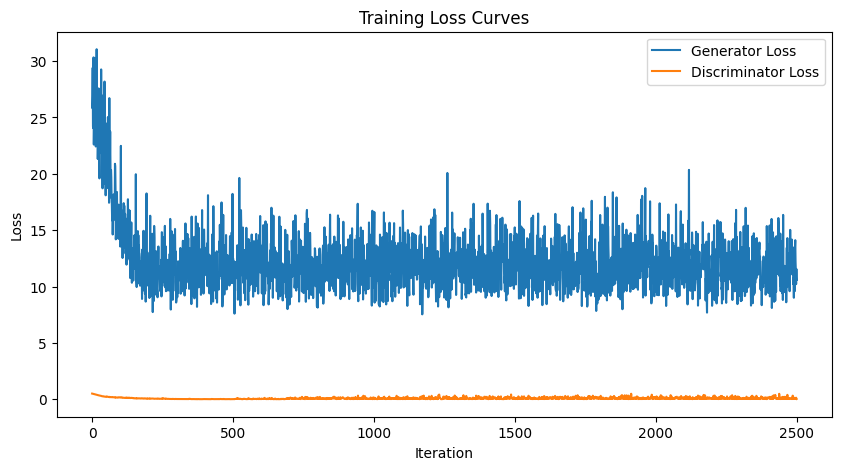

NameError: name 'train_psnrs' is not defined

<Figure size 1000x500 with 0 Axes>

In [21]:
# ======================
# --- PLOTTING METRICS
# ======================
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()


# Plotting
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(val_psnrs) + 1), val_psnrs, marker='o', color='blue', linewidth=2)
plt.title('Validation PSNR per Epoch')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🧪 Inference & Evaluation on Test Set

- **Model Loading**: Loads the best generator checkpoint (`G_best.pt`) for evaluation.
- **Single Sample Inference**:
  - Visualizes SAR VV/VH, generated EO, and ground-truth EO using `show_sample`.
  - Computes PSNR and SSIM for one randomly selected test sample.

- **Full Test Set Evaluation**:
  - Iterates over the test set to compute **average PSNR** and **SSIM** across all samples.
  - Uses `denormalize()` to ensure evaluation is done in the [0, 1] range.

This final step benchmarks the trained model’s performance on unseen SAR inputs.


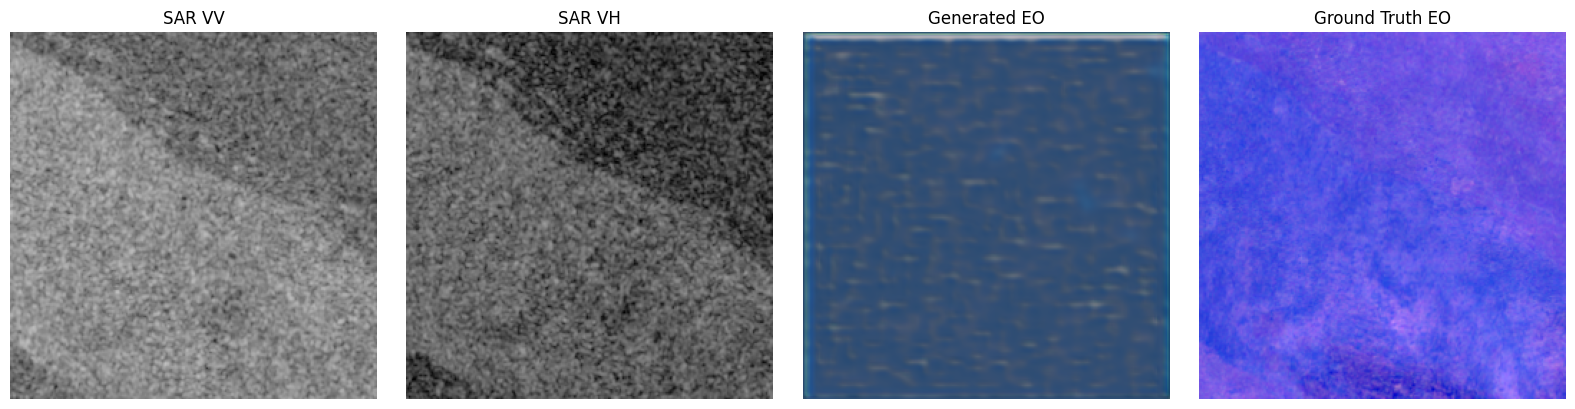

🔍 PSNR (1 sample): 11.24 dB
🔍 SSIM (1 sample): 0.5791

📊 Average PSNR on Test Set: 18.84 dB
📊 Average SSIM on Test Set: 0.5842


In [22]:
import torch
import random
from pytorch_msssim import ssim
from torchvision.utils import save_image

# Load best saved model
G.load_state_dict(torch.load(f"{checkpoint_dir}/G_best.pt"))
G.eval()

def compute_multiband_ssim(fake, real):
    """Computes SSIM across all bands (C, H, W) in [0, 1] range."""
    if fake.ndim == 3:
        fake = fake.unsqueeze(0)
        real = real.unsqueeze(0)
    return ssim(fake, real, data_range=1.0, size_average=True).item()

# --- Inference on One Random Sample ---
with torch.no_grad():
    real_A, real_B = next(iter(test_loader))
    real_A = real_A.to(device)
    real_B = real_B.to(device)
    fake_B = G(real_A)

    # Random index selection
    idx = random.randint(0, real_A.size(0) - 1)

    show_sample(real_A, fake_B, real_B, idx=idx)

    pred = denormalize(fake_B[idx].cpu())
    gt   = denormalize(real_B[idx].cpu())

    psnr_val = compute_psnr(pred, gt)
    ssim_val = compute_multiband_ssim(pred, gt)

    print(f"🔍 PSNR (1 sample): {psnr_val:.2f} dB")
    print(f"🔍 SSIM (1 sample): {ssim_val:.4f}")

# --- Inference on Full Test Set ---
total_psnr = 0.0
total_ssim = 0.0
count = 0

with torch.no_grad():
    for real_A, real_B in test_loader:
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        fake_B = G(real_A)

        for i in range(real_A.size(0)):
            pred = denormalize(fake_B[i].cpu())
            gt   = denormalize(real_B[i].cpu())

            total_ssim += compute_multiband_ssim(pred, gt)
            total_psnr += compute_psnr(pred, gt)
            count += 1

avg_psnr = total_psnr / count
avg_ssim = total_ssim / count

print(f"\n📊 Average PSNR on Test Set: {avg_psnr:.2f} dB")
print(f"📊 Average SSIM on Test Set: {avg_ssim:.4f}")

# 🖼️ Save Side-by-Side SAR | Generated EO | Ground Truth EO Images

- **Function**: `save_side_by_side_images`
  - Saves triplet grids showing:
    - SAR input (denormalized)
    - Generated EO output
    - Ground truth EO image
  - Outputs one `.png` per sample in the batch.

- **Usage**:
  - Runs inference on a batch from the test set.
  - Saves visual results in the `generated_grids/` directory for easy inspection.

Helps in **qualitative analysis** of model performance across test samples.


In [ ]:
import os
import torch
from torchvision.utils import make_grid, save_image

def save_side_by_side_images(sar_batch, fake_batch, real_batch, output_dir="generated_grids"):
    os.makedirs(output_dir, exist_ok=True)

    sar_batch = denormalize(sar_batch.cpu())
    fake_batch = denormalize(fake_batch.cpu())
    real_batch = denormalize(real_batch.cpu())

    for i in range(sar_batch.size(0)):
        triplet = torch.stack([sar_batch[i], fake_batch[i], real_batch[i]])  # Shape: (3, C, H, W)
        grid = make_grid(triplet, nrow=3, padding=2)
        save_image(grid, f"{output_dir}/sample_{i:03d}.png")

    print(f"✅ Saved {sar_batch.size(0)} side-by-side image triplets in '{output_dir}/'")

# Generate & Save
with torch.no_grad():
    real_A, real_B = next(iter(test_loader))
    real_A = real_A.to(device)
    real_B = real_B.to(device)
    fake_B = G(real_A)

    save_side_by_side_images(real_A, fake_B, real_B)

### 📦 Export Trained Model Checkpoints as ZIP

- **Purpose**: Zips the contents of the `checkpoints/` directory for easy download.
- Uses `tqdm` for progress visualization while zipping.
- Generates a downloadable link using `FileLink`.

Helpful for exporting your trained generator/discriminator models from Kaggle.


In [ ]:
import os
import zipfile
from tqdm import tqdm
from IPython.display import FileLink

# Define paths
folder_to_zip = "checkpoints"
zip_filename = "model_checkpoint.zip"

# Create a zip file with tqdm progress
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_to_zip):
        for file in tqdm(files, desc="Zipping checkpoints"):
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, start=folder_to_zip)
            zipf.write(filepath, arcname=arcname)

# Create a download link
FileLink(zip_filename)